# Transfer learning using Wide Residual Networks

In this notebook, we  will learn how to classify CIFAR-10 by using transfer learning from a pretrained network.

A Wide Residual Network (WRN) model was previously trained on ImageNet 224x224, ImageNet 64x64, and ImageNet
32x32 using cross-entropy and triplet loss.

The intuition behind transfer learning for image classification is that if a model is trained on a large dataset,
this model will have a better generalisation than training from scratch.

In this notebook:
We will add classification layers at the top of base model i.e., WRN. Following that, joint training of both the
newly-added classifier layers and the base model will be performed.

We will follow the general machine learning workflow.

1. Examine and understand the data
1. Build an input pipeline, in this case using tensoflow dataset API
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [1]:
# imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from  wrn import wide_residual_network

## Data Preparation

In [2]:
ds, ds_info = tfds.load("cifar10", split=['train', 'test'], shuffle_files=True, 
                                       as_supervised=True,with_info=True)
ds_train, ds_test = ds

Show few examples from test examples.

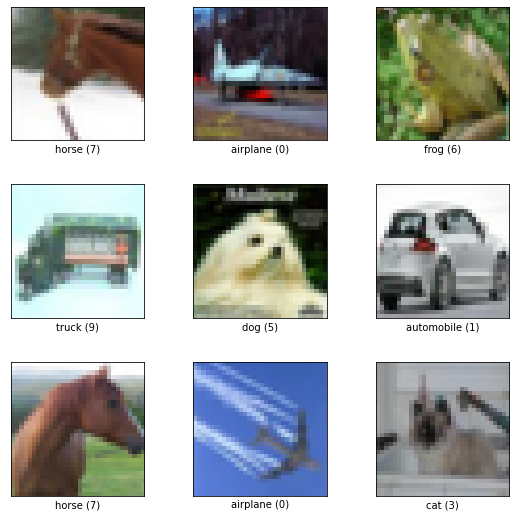

In [3]:
fig = tfds.show_examples(ds_test, ds_info)

 Rescale pixel values


In [4]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

Data rescaling, batching and preparing for training.

In [5]:
# data pipeline
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 128

ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)

ds_train = ds_train.batch(batch_size)
ds_test = ds_test.batch(batch_size)

ds_train = ds_train.prefetch(AUTOTUNE)
ds_test = ds_test.prefetch(AUTOTUNE)

### Creating a base model
Creating a base model with pretrained weights `imagenet32` i.e., trained on ImageNet 32x32 using cross-entropy loss.
The weights can be `imagenet32`, `imagenet64`,`imagenet-full`, or  `imagenet-triplet`. The weight files can be downloaded
from  [releases](https://github.com/attaullah/Pretraining-WideResNet/releases).

In [ ]:
#skip this if you have already downloaded weights. 
# create weights directory  if not exists
!mkdir weights
%cd weights/
# ImageNet 32x32 pretrained weights using cross-entropy loss
!wget https://github.com/attaullah/Pretraining-WideResNet/releases/download/v1/32x32-CE-weights.h5

# ImageNet 32x32 pretrained weights using triplet loss
!wget https://github.com/attaullah/Pretraining-WideResNet/releases/download/v1/32x32-Triplet-weights.h5

# ImageNet 64x64 pretrained weights using cross-entropy loss
!wget https://github.com/attaullah/Pretraining-WideResNet/releases/download/v1/64x64-CE-weights.h5

# ImageNet 224x224 pretrained weights using cross-entropy loss
!wget https://github.com/attaullah/Pretraining-WideResNet/releases/download/v1/imagenet-full-CE-weights.h5

%cd ..

In [6]:
num_classes = 10
base_model = wide_residual_network(depth=28, width=2, input_shape=(32,32,3),weights="imagenet32")

Let's take a look at the base model architecture.

In [7]:
base_model.summary()

Model: "wide-resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________________________

## Adding a classification head

Adding a a dense layer with softmax activation at the bottom of `base_model`.

In [8]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Dense(10, activation="softmax", name="fc1"))

Compile model using cross-entropy loss and ADAM as an optimiser.

In [9]:
learning_rate = 1e-4

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate), metrics=['acc'])

Full model summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide-resnet (Functional)     (None, 128)               1471968   
_________________________________________________________________
fc1 (Dense)                  (None, 10)                1290      
Total params: 1,473,258
Trainable params: 1,469,642
Non-trainable params: 3,616
_________________________________________________________________


Model accuracy before start of the training.

In [11]:
loss0, accuracy0 = model.evaluate(ds_test)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}%".format(100. * accuracy0))

79/79 [==============================] - 16s 101ms/step - loss: 5.5715 - acc: 0.1007
initial loss: 5.55
initial accuracy: 9.74%


Model training

In [12]:
initial_epochs = 10

history = model.fit(ds_train, epochs=initial_epochs, validation_data=ds_test)

Epoch 1/10
391/391 [==============================] - 48s 91ms/step - loss: 0.6224 - acc: 0.7992 - val_loss: 0.3467 - val_acc: 0.8810
Epoch 2/10
391/391 [==============================] - 15s 38ms/step - loss: 0.2390 - acc: 0.9171 - val_loss: 0.2828 - val_acc: 0.9011
Epoch 3/10
391/391 [==============================] - 15s 38ms/step - loss: 0.1605 - acc: 0.9469 - val_loss: 0.2479 - val_acc: 0.9159
Epoch 4/10
391/391 [==============================] - 15s 38ms/step - loss: 0.1100 - acc: 0.9668 - val_loss: 0.2388 - val_acc: 0.9201
Epoch 5/10
391/391 [==============================] - 15s 38ms/step - loss: 0.0728 - acc: 0.9818 - val_loss: 0.2403 - val_acc: 0.9210
Epoch 6/10
391/391 [==============================] - 15s 38ms/step - loss: 0.0454 - acc: 0.9915 - val_loss: 0.2486 - val_acc: 0.9228
Epoch 7/10
391/391 [==============================] - 15s 38ms/step - loss: 0.0263 - acc: 0.9972 - val_loss: 0.2634 - val_acc: 0.9223
Epoch 8/10
391/391 [==============================] - 15s 38ms

Model Evaluation

In [13]:
loss, accuracy = model.evaluate(ds_test)
print('Test accuracy : {:.2f}%'.format(100. * accuracy))

79/79 [==============================] - 1s 11ms/step - loss: 0.2710 - acc: 0.9276
Test accuracy : 92.76%


### Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss.

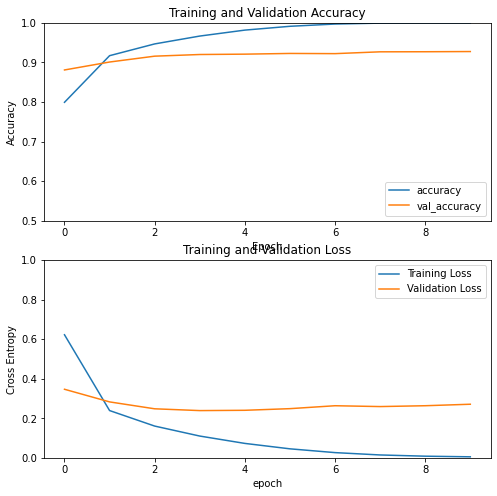

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
